In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/
!ls

# Vanilla GAN



Discriminator : 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


Generator : 


Model: "sequential_3"
______________________________________________________________

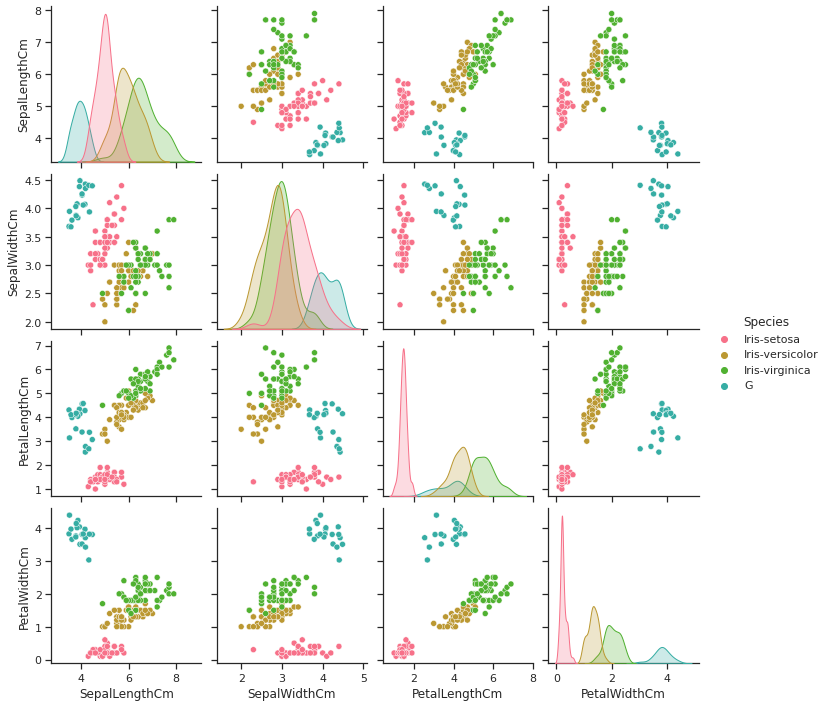

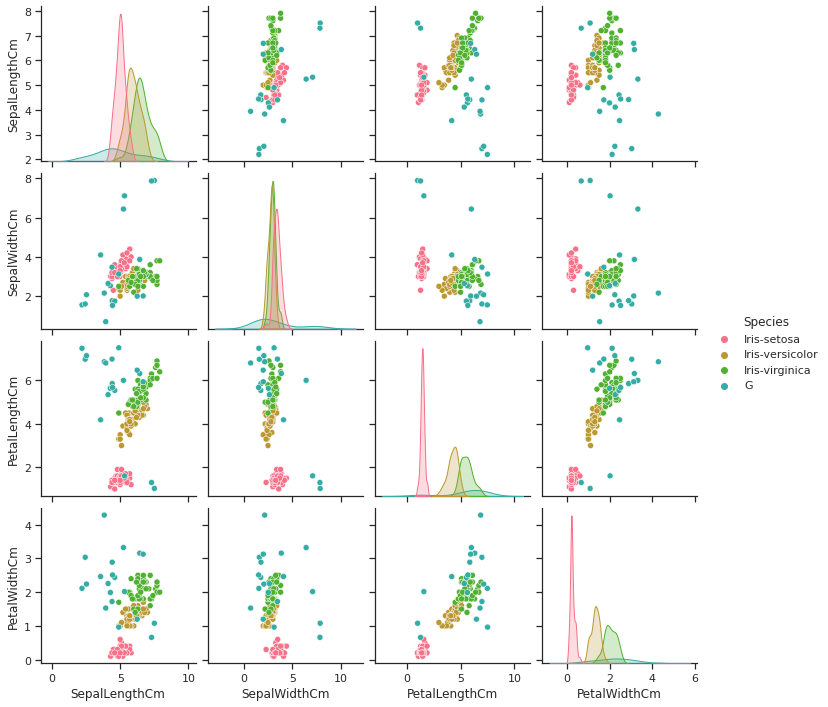

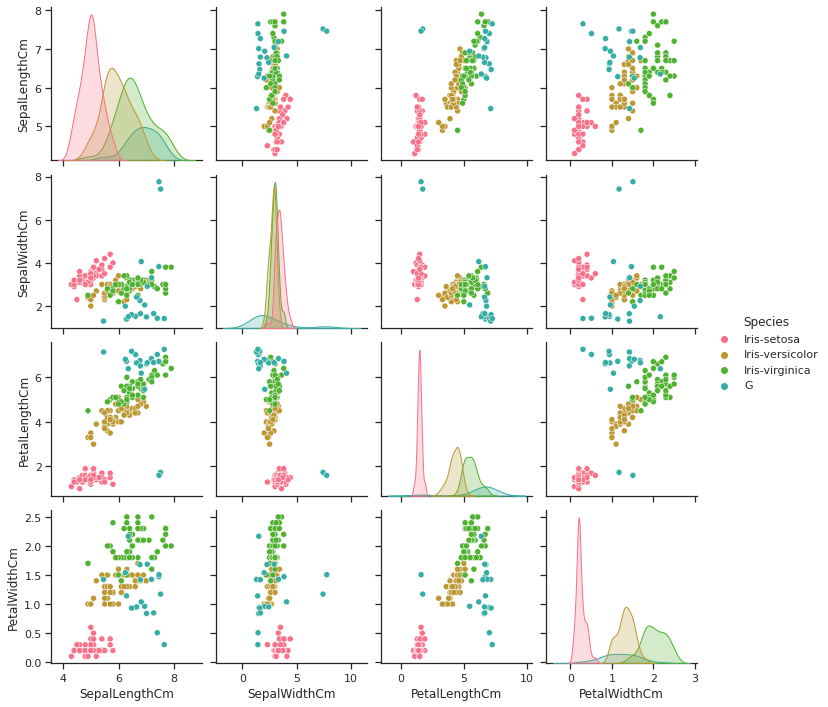

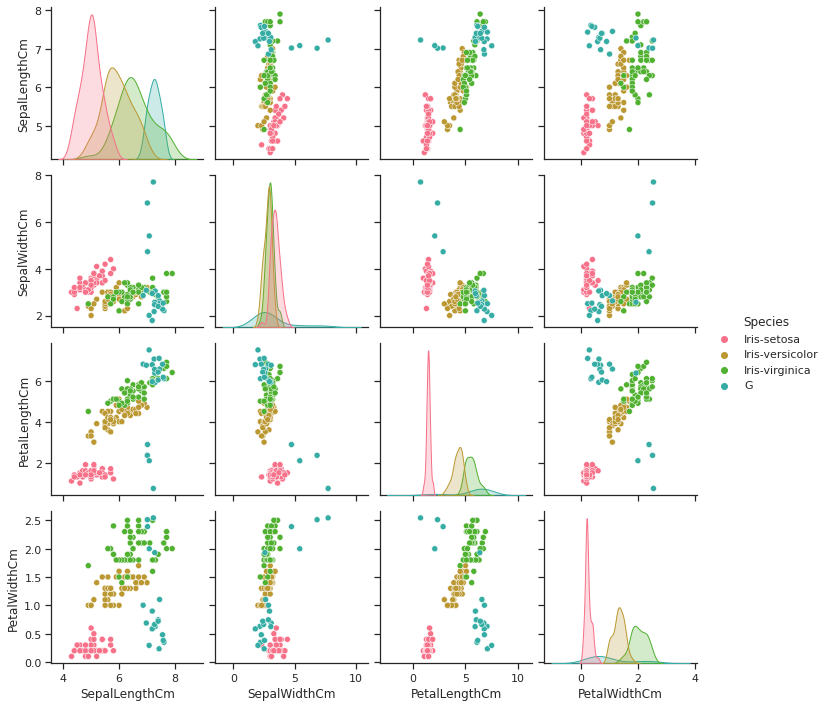

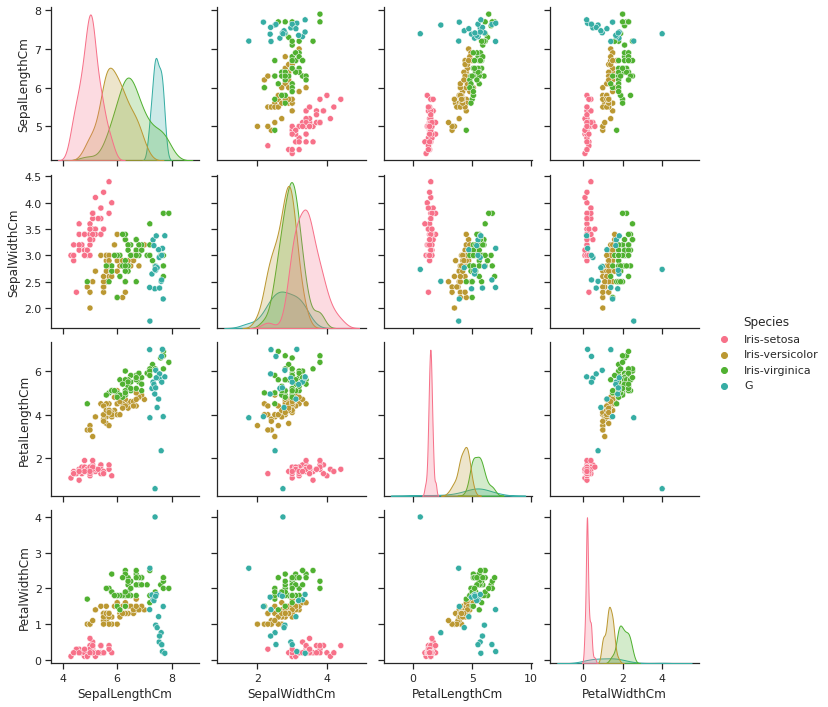

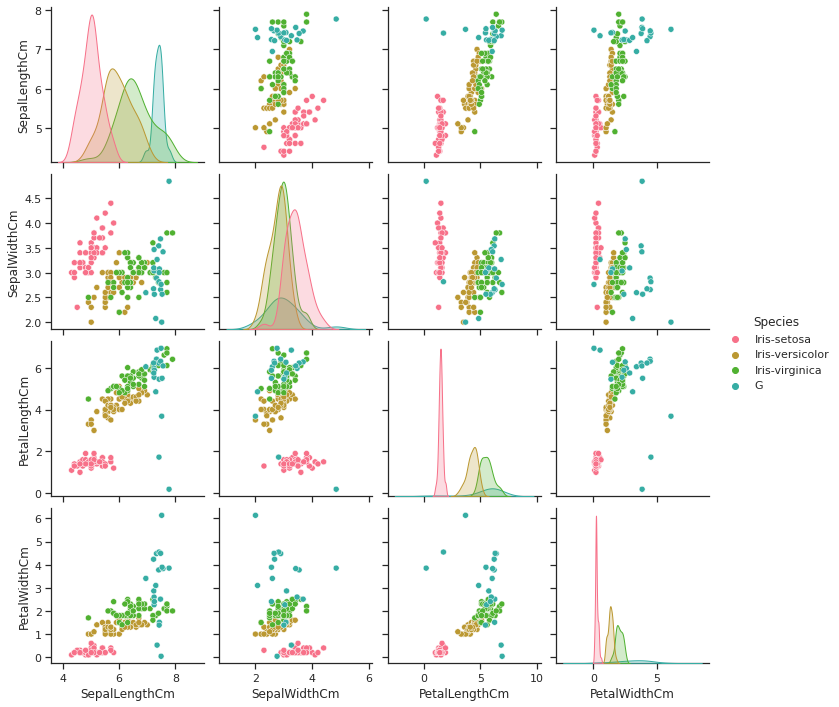

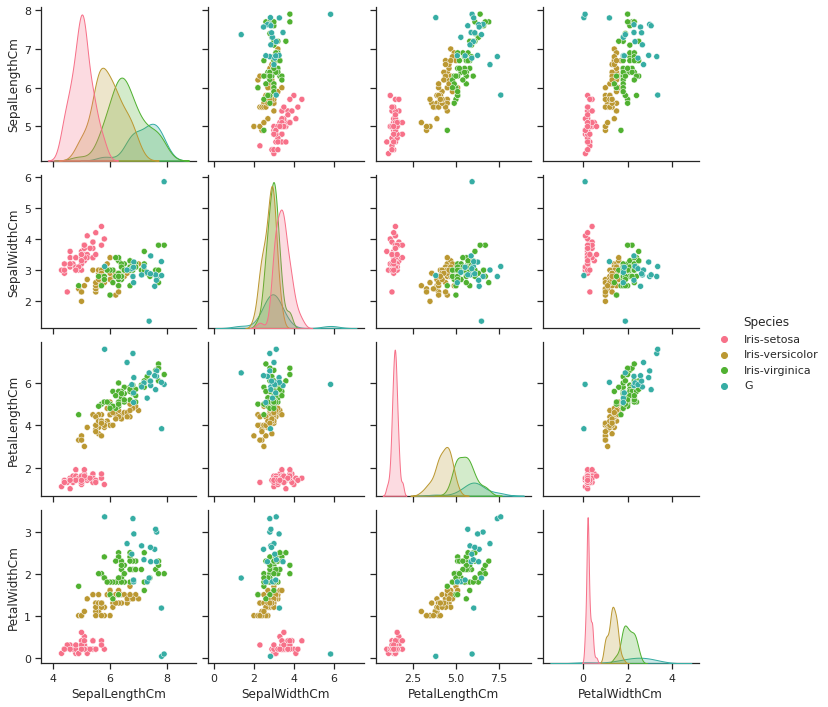

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

class GAN():

    def __init__(self):

        #formats des entrés
        self.latent_dim = 10
        self.vectorSize = 4

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()

        # ------ Construction du modèle combiné -------
        z = Input(shape=(self.latent_dim,)) # z input un bruit
        vector = self.generator(z) # z --> vecteur 4-dim
        self.discriminator.trainable = False 
        validity = self.discriminator(vector) #vecteur 4-dim -> validity (1) = 0/1
        
        self.combined = Model(z, validity) #definition du modèle combiné
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def getSample(self):
      return self.sample

    def build_generator(self):

        model = Sequential()

        #Couches
        model.add(Dense(6, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(10))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.vectorSize, activation='tanh'))

        print("\n\nGenerator : \n\n")
        model.summary()#On affiche le résumé
        
        #input & output
        label = Input(shape=(self.latent_dim,))
        vector = model(label)
        
        return Model(label, vector) #On renvoit notre model

    def build_discriminator(self):

        model = Sequential()
        
        #Couches
        model.add(Dropout(0.2, input_shape=(4,)))
        model.add(Dense(10,activation='tanh'))
        model.add(Dense(8,activation='tanh'))
        model.add(Dense(6,activation='tanh'))
        model.add(Dense(1, activation='sigmoid'))

        print("\n\nDiscriminator : \n\n")
        model.summary()#On affiche le résumé
        
        #input & output
        vector = Input(shape=(self.vectorSize, ))
        validity = model(vector)
        
        return Model(vector, validity) #On renvoit notre model

    def train(self, epochs, batch_size=128, sample_interval=50):

        # chargement du jeu de données à partir de l'URL
        url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
        names = ['SepalLengthCm', 'SepalWidthCm', 
                'PetalLengthCm', 'PetalWidthCm', 
                'Species']

        # creation d'un dataframe pour récupérer les données
        self.df_iris = pd.read_csv(url, names=names)

        array = self.df_iris.values #necessité de convertir le dataframe en numpy

        X_train = self.df_iris.iloc[:,0:4].values
        X_train = X_train[101:150]
        y_train = self.df_iris.iloc[:,4].values

        # 0 -->setosa, 1 -->versicolor, 2 -->virginica
        encoder =  LabelEncoder()
        y_train = encoder.fit_transform(y_train)

        # y_train = pd.get_dummies(y_train).values
        self.maxVal = np.amax(X_train)
        X_train = X_train / (self.maxVal/2) - 1. #redimensionne --> [-1, 1]
        valid = np.ones((batch_size, 1)) # (20 x 1) de 1
        fake = np.zeros((batch_size, 1)) # (20 x 1) de 0

        for epoch in range(epochs):
            
            idx = np.random.randint(0, X_train.shape[0], batch_size) #(20, ) tableau d'entiers aleatoires entre 0 et 150
            vectors = X_train[idx] #(20 x 4) le lot (batch)

            noise = np.random.randint(3, size=(batch_size, self.latent_dim)) #(20 x 100)
            gen_vec = self.generator.predict(noise) #(20 x 4)

            d_loss_real = self.discriminator.train_on_batch(vectors, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_vec, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #perte du discriminateur

            noise = np.random.randint(3, size=(batch_size, self.latent_dim)) #(20 x 100)
            g_loss = self.combined.train_on_batch(noise, valid)#perte du générateur (modele combiné)

            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if (epoch/5) % sample_interval == 0:
              self.sample_vectors(epoch)

    def sample_vectors(self, epoch):
      labels = np.random.randint(3, size=(20, self.latent_dim)) #(1x20)
      print("\nepoch : " + str(epoch) + "\n")
      sam = self.generator.predict(labels)
      sam = (sam+1) * self.maxVal/2
      # print(sam)
      self.sample = sam

      labs = np.empty(([sam.shape[0], ]), dtype=str)
      labs[:] = "G"

      df = pd.DataFrame(data=sam, columns=self.df_iris.columns[0:4])
      df[self.df_iris.columns[4]] = labs

      df = pd.concat([self.df_iris, df])
      sns.set(style="ticks")
      sns.set_palette("husl")
      sns.pairplot(df.iloc[:,0:5],hue="Species")
      #sauvegarder dans un fichier texte 

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3001, batch_size=20, sample_interval=100)
   

In [ ]:
import pandas as pd
import numpy as np

# Le jeu de données est disponible sur le site de l'UCI
# https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

# chargement du jeu de données à partir de l'URL
url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['SepalLengthCm', 'SepalWidthCm', 
         'PetalLengthCm', 'PetalWidthCm', 
         'Species']

# creation d'un dataframe pour récupérer les données
df_iris = pd.read_csv(url, names=names) #DataFrame


# Conversion du dataframe
array = df_iris.values #necessité de convertir le dataframe en numpy

# Récupération des différentes colonnes
#X matrice représentant les variables prédictives 
X = array[:,0:4] 
#y vecteur : représentant la variable à prédire
y = array[:,4]

# print(X)
print(y)

# affichage du nombre de classes et de val
print ("Nombre d'occurrences par classe : \n",df_iris['Species'].value_counts())
import sklearn
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

# création de l'estimateur 
clf.fit(X, y) 

print(clf.predict(gan.getSample()))

print(gan.getSample())
print(X[120:150])
print(y[120:150])

sns.displot(gan.getSample())


In [ ]:
sns.set(style="ticks")
sns.set_palette("husl")
sns.pairplot(df_iris,hue="Species")

#CGAN

In [ ]:
import pandas as pd
import numpy as np

# Le jeu de données est disponible sur le site de l'UCI
# https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

# chargement du jeu de données à partir de l'URL
url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['SepalLengthCm', 'SepalWidthCm', 
         'PetalLengthCm', 'PetalWidthCm', 
         'Species']

# creation d'un dataframe pour récupérer les données
df_iris = pd.read_csv(url, names=names) #DataFrame
display(df_iris)

# Conversion du dataframe
array = df_iris.values #necessité de convertir le dataframe en numpy

# Récupération des différentes colonnes
#X matrice représentant les variables prédictives 
X = array[:,0:4] 
#y vecteur : représentant la variable à prédire
y = array[:,4]

# print(X)

# affichage du nombre de classes et de val
print ("Nombre d'occurrences par classe : \n",df_iris['Species'].value_counts())

In [ ]:
# Load custom functions

import GAN_171103

# For reloading after making changes
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *

rand_dim = 10
base_n_count = 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# label_cols = [ i for i in train.columns if 'Class' in i ]
# data_cols = [ i for i in train.columns if i not in label_cols ]
# train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
# train_no_label = train[ data_cols ]

In [ ]:
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
# adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN